In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import poisson as ps
from scipy.interpolate import make_interp_spline, BSpline

In [164]:
def poisson(x, mean):
    return ps.pmf(x, mean)

# units_codelife is a numpy array (units, codelife_remaining). It has shape (n, 2) where n is the lead_time.

class LossSimulation:
    def __init__(self, days_codelife, unit_sales_per_day, units_per_case, lead_time):
        self.days_codelife = days_codelife
        self.unit_sales_per_day = unit_sales_per_day
        self.units_per_case = units_per_case
        self.lead_time = lead_time

        # Initialise the inventory. This is a list of (n_units, codelife_remaining) lists where n_units is the number of units in the case and codelife_remaining is the number of days remaining before the code expires.
        self.n_units, self.codelife_remaining, self.days_till_active = self.initialise_inventory()

    def initialise_inventory(self):
        n_units = np.ones(1) * self.units_per_case
        codelife_remaining = np.ones(1) * self.days_codelife
        days_till_active = np.ones(1) * 0
        return n_units, codelife_remaining

    def simulate(self, days_code_life, unit_sales_per_day, units_per_case):
        """Run the simulation to calculate the loss for a given set of parameters.

        Each day do the following:
            1. Calculate the probability of a stockout for the current inventory at lead_time in the future. 
                1a. If the probability is below the threshold, then we don't order any more stock. 
                1b. If the probability is above the threshold, then we order more stock. 
            2. Update the inventory by subtracting the units sold today.
            3. At the end of the day:
                3a. Calculate the units wasted.
                3b. Calculate whether we had a stockout.
        """

    def inventory_to_forecast(self, inventory_n_units, inventory_codelife_remaining):
        # Convert the inventory into a list of (n_units, codelife_remaining) where we sum across all items in inventory. 
        # This is used to calculate the chance of selling out before the lead time is up.

        n_units = np.zeros(self.lead_time, dtype=int)
        days_left = np.arange(1, self.lead_time + 1)

        for units, codelife_remaining in zip(inventory_n_units, inventory_codelife_remaining):
            idx = codelife_remaining - 1
            if codelife_remaining >= self.lead_time:
                n_units[-1] += units
            else:
                n_units[idx] += units

        return n_units, days_left
    
    def probability_stockout(self, n_units, days_left, rotation_weighting = True):
        """We calculate the probability of a stockout as follows:
        Take in the number of units at each remaining day of codelife, units with remaining codelife that exceeds the shelf_life are aggregated.

        WEIGHTING:
        If rotation_weighting is True:
            1. Assume the sales for a given day fall entirely on product with lowest codelife_remaining. 
            2. Calculate the expected sales for first group as the min(sales per day * remaining days, units remaining).
            3. Calculate the expected sales for the second group as the min(sales per day * remaining days - expected sales for previous groups, units_remaining).
            4. Repeat for all groups.
            5. For the final group, calculate the expected sales as sales per day * remaining days - expected sales for previous groups. We don't cap this at the maximum so we can accurately represent the probability of a stockout. 
        If rotation_weighting is False:
            1. Assume the sales for a given day are distributed evenly across all products and are weighted by the unit days available as a fraction of the total. 
            2. Calculate the expected sales for the first group as (sales per day * remaining days) * (n_units * remaining days for this group) / (sum of n_units * remaining days for all groups).

            
        STOCKOUT PROBABILITY:
        Then the probability of a stockout is the probability of selling at least the n_units for the final group, which we can calculate from the poisson distribution.
            P(stockout) = 1 - P(selling < n_units) = 1 - sum(P(selling = i) for i in range(n_units))

        WASTED UNITS:
        We can calculate the expected number of wasted units.
            1. For all but the final group, calculate the probability of selling i units, and therefore of having (n_units - i) remaining.
            2. Sum P(selling = i) * (n_units - i) for i in range(n_units) to get the expected number of wasted units for this group.
            3. Sum across all these groups to get the total expected number of wasted units.  
        NB we don't calculate this at the moment.
        
        Expected behaviour should follow the following general features:
            1. Rotating stock should reduce the probability of a stockout, since sales are weighted towards the end of codelife. This both increases availability and reduces waste.
    
        """

        expected_sales = np.zeros(len(n_units))

        if rotation_weighting:
            expected_sales[0] = min(self.unit_sales_per_day * days_left[0], n_units[0])
            for i in range(1, len(n_units) - 1):
                expected_sales[i] = min(self.unit_sales_per_day * days_left[i] - sum(expected_sales[:i]), n_units[i])
            expected_sales[-1] = self.unit_sales_per_day * days_left[-1] - sum(expected_sales[:-1])
        else:
            total_unit_days = np.sum(n_units * days_left)
            expected_sales = self.unit_sales_per_day * days_left * n_units * days_left / total_unit_days

        # Calculate the probability of selling at least the expected sales for the final group
        prob_stockout = 1 - np.sum(poisson(np.arange(n_units[-1]), expected_sales[-1]))

        print(expected_sales)
        return prob_stockout
        
    def update_inventory(self, n_units, rotation_weighting = True):
        """Calculate the expected sales for each day by sampling from the poisson distribution with mean equal to the expected sales per day. 

        If rotation_weighting is True:
            1. Assume the sales for a given day fall entirely on group with lowest codelife_remaining. 
            2. Calculate the actual sales for the first group as the min(sales_today, units remaining).
            3. Calculate the actual sales for the second group as the min(remaining_sales_today, units_remaining).
            4. Repeat for all groups.
            5. For the final group, calculate the actual sales as sales per day * remaining days - expected sales for previous groups.

        If rotation_weighting is False:
            1. Randomly assign the sales for a given day to each group, weighting by the units remaining in that group
        """

        sales_today = ps.rvs(self.unit_sales_per_day)
        sales = np.zeros(len(n_units))

        print('Sales today:', sales_today)

        if rotation_weighting:
            sales[0] = min(sales_today, n_units[0])
            for i in range(1, len(n_units)):
                sales[i] = min(sales_today - sum(sales[:i]), n_units[i])
        else:
            # Sample from the multinomial distribution to get the number of units sold from each group. Never sample more than the minimum number of units in any group. 
            # Repeat until we have assigned all the sales for today, or until no units are left.
            original_sales_today = sales_today
            while sales_today > 0 and np.sum(n_units - sales) > 0:
                sales_today -= 1
                weights = (n_units - sales) / np.sum(n_units - sales)
                sales += np.minimum(np.random.multinomial(1, weights), n_units)
                print(sales_today, sales, n_units)

            assert np.sum(sales) == np.min([original_sales_today, np.sum(n_units)])
        
        
        return n_units - sales




In [426]:
def update_units_sales(p_sales, p_units):
    """Given the log probability of observing a given number of sales and the probability of having a given number of units, calculate the probability of having a given number of units left, and the probability of observing a given number of sales after selling through the available units. 
    In the future we can consider including logsumexp to avoid underflow errors. But for now we'll implement the logic without.
    """
    n_sales, n_units = p_sales.shape[0], p_units.shape[0]
    updated_p_sales = np.zeros(n_sales)
    updated_p_units = np.zeros(n_units)

    # Calculate the probability of selling a given number of units
    p_matix = p_sales[:, np.newaxis] * p_units[np.newaxis, :]

    for i in range(1, n_sales):
        updated_p_sales[i] = np.sum(np.diagonal(p_matix, offset=-i))
    updated_p_sales[0] = 1 - np.sum(updated_p_sales[1:])

    for i in range(1, n_units):
        updated_p_units[i] = np.sum(np.diagonal(p_matix, offset=i))
    updated_p_units[0] = 1 - np.sum(updated_p_units[1:])

    return updated_p_sales, updated_p_units

def probability_stockout_rotation(n_units, days_left, unit_sales_per_day, lead_time, codelife, verbose = True):
    """
    If rotation_weighting = True, then this is an in depth calculation if you don't simulate it. This is because we need to keep track of lots of probabilities. 
    1. Determine the number of distinct intervals there are seperated by moments that stock becomes active, or stock becomes available in store as a result of a delivery. This gives you a series of intervals with a given number of days seperating them. 
    2. For the first interval, we start with a guaranteed probability of having the starting number of units in each group. This can be represented as sparse probability distribution which is equal to zero everywhere except at the starting number of units. Populate these distributions for each group. 
        2a. Still in the first interval, calculate the mean number of sales as the days in that interval * sales per day.
        2b. Calculate the resulting probability distribution for sales up to 5 standard deviations above the mean using the poisson distribution. 
        2c. Starting with the first group, calculate the new distribution of units remaining and the new distribution of sales. 
        2d. Take the new distribution of sales and apply this to the next group, and repeat until you reach the final group. 
    3. For the second interval, we start with a the probability distribution that we calculated from the first interval. We now begin at the second group, and repeat the process from 2c onwards. 
    4. Repeat for all intervals. If you have a delivery on a given day, then you need to update add that to the processed groups for the next interval.     
    """
    # Do a quick check to see if we have any active stock at the end of the lead time. If not, then we can return a stockout probability of 1.
    active_groups = (days_left - lead_time > 0) & (days_left - lead_time <= codelife)
    if not np.any(active_groups):
        return 1

    # Initialise the probability distributions for each group. 
    assert len(n_units) == len(days_left)
    p_units_list = []

    for i in range(len(n_units)):
        p_units_list.append(np.zeros(n_units[i] + 1))
        p_units_list[-1][-1] = 1

    # Calculate the intervals where stock expires or enters the system.
    interval_edges = np.sort(np.unique(np.concatenate([[0], [lead_time], days_left[days_left <= codelife], days_left[days_left > codelife] - codelife])))
    interval_edges = interval_edges[interval_edges <= lead_time]
    intervals = np.diff(interval_edges)

    if verbose:
        print('interval_edges', interval_edges)
        print('intervals', intervals)

    # Start the main logic loop
    days_ahead = 0
    for i, interval in enumerate(intervals):
        # Active groups are those where they haven't expired (days_left > days_ahead), and they have entered the active stockpile (days_left - days_ahead <= codelife)
        not_expired = (days_left - days_ahead > 0)
        entered_stockpile = (days_left - days_ahead <= codelife)
        active_groups = not_expired & entered_stockpile
        active_idx = np.argwhere(active_groups).flatten()
        active_p_units_list = [p_units_list[i] for i in active_idx]

        if verbose:
            print('Days Ahead:              ', days_ahead)
            print('Expired Groups:          ', np.argwhere(np.logical_not(not_expired)).flatten())
            print('ACTIVE Groups:           ', active_idx)
            print('Not Entered Stockpile:   ', np.argwhere(np.logical_not(entered_stockpile)).flatten())
            print('Active Probability Dists:')
            for active_id, p_units in zip(active_idx, active_p_units_list):
                print('Group', active_id, 'p_units', p_units)
            print()

        
        expected_sales = unit_sales_per_day * interval
        max_sales = int(expected_sales + 5 * np.sqrt(expected_sales))

        # Calculate the probability of selling a given number of units
        p_sales = poisson(np.arange(max_sales), expected_sales)

        # Propagate the probability distribution forwards
        active_p_units_list = propagate_probability(p_sales, active_p_units_list)

        # Update the probability distributions for the active groups
        for active_idx, all_idx in enumerate(active_idx):
            p_units_list[all_idx] = active_p_units_list[active_idx]

        # Update the days ahead
        days_ahead += interval

    # Calculate the probability of a stockout
    prob_stockout = 1
    for p_units in p_units_list:
        prob_stockout *= np.sum(p_units[0])

    return prob_stockout

def propagate_probability(p_sales, p_units_list):
    updated_p_units_list = []

    for p_units in p_units_list:
        # As we propagate forwards, we update the sales probability distribution and the units probability distribution.
        # When we've updated all the probability distributions, we return the list.
        p_sales, updated_p_units = update_units_sales(p_sales, p_units)
        updated_p_units_list.append(updated_p_units)
    
    return updated_p_units_list


In [425]:
n_units = np.array([2,0,33])
days_left = np.array([1,2,4])
lead_time = 3
codelife = 4
unit_sales_per_day = 11

probability_stockout_rotation(n_units, days_left, unit_sales_per_day, lead_time, codelife, verbose = False)

0.3865056936992112

In [373]:
days_ahead = lead_time
active_groups = (days_left - days_ahead > 0) & (days_left - days_ahead <= codelife)
np.any(active_groups)

False

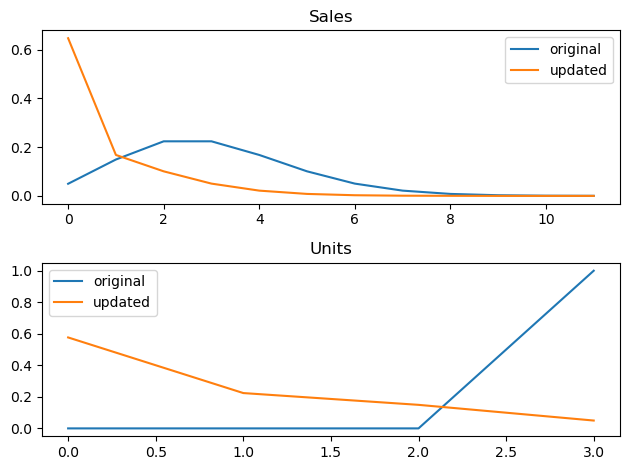

In [272]:
fig, axs = plt.subplots(2,1)

axs[0].plot(p_sales, label = 'original')
axs[0].plot(u_p_sales, label = 'updated')
axs[1].plot(p_units, label = 'original')
axs[1].plot(u_p_units, label = 'updated')

axs[0].legend()
axs[1].legend()

axs[0].set_title('Sales')
axs[1].set_title('Units')

plt.tight_layout()
plt.show()

In [175]:
x = np.arange(0,25).reshape(5,5)
print(x)
print(np.diagonal(x, 1).shape[0])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
4


In [161]:
days_code_life = 7
unit_sales_per_day = 5
units_per_case = 6
lead_time = 3
availability_weighting = 1

sim = LossSimulation(days_code_life, unit_sales_per_day, units_per_case, lead_time)

n_units = np.array([2, 2, 1])
codelife_remaining = np.array([1, 2, 3])
n_units, days_left = sim.inventory_to_forecast(n_units, codelife_remaining)

# print(n_units)
# print(days_left)

# sim.probability_stockout(n_units, days_left, rotation_weighting = True)
sim.update_inventory(n_units, rotation_weighting = False)

Sales today: 8
7 [0. 1. 0.] [2 2 1]
6 [1. 1. 0.] [2 2 1]
5 [2. 1. 0.] [2 2 1]
4 [2. 2. 0.] [2 2 1]
3 [2. 2. 1.] [2 2 1]


array([0., 0., 0.])

In [140]:
days_code_life = 7
unit_sales_per_day = 1
units_per_case = 6
availability_weighting = 1

a_loss, w_loss, p_sell_case, p_rem_stock = get_availability_waste(days_code_life, days_restock, unit_sales_per_day, units_per_case)
# stats = get_min_availability_waste(days_code_life, unit_sales_per_day, units_per_case, availability_weighting)
# plot_loss_curve(days_code_life, unit_sales_per_day, units_per_case, availability_weighting, smooth = True)
# fixed_code_life_plot()


NameError: name 'get_availability_waste' is not defined

In [4]:
code_life_range = np.arange(1,20, 2)
sales_range = np.arange(1,40, 2)
case_range = np.arange(1,40, 2)

# Calculate the total loss and put it all into a pandas dataframe
code_life_ls = []
sales_ls = []
case_ls = []
a_loss_ls = []
w_loss_ls = []
restock_ls = []


for code_life in code_life_range:
    for unit_sales_per_day in sales_range:
        for units_per_case in case_range:
            stats = get_min_availability_waste(code_life, unit_sales_per_day, units_per_case, availability_weighting)
            restock, a_loss, w_loss = stats
            code_life_ls.append(code_life)
            sales_ls.append(unit_sales_per_day)
            case_ls.append(units_per_case)
            a_loss_ls.append(a_loss)
            w_loss_ls.append(w_loss)
            restock_ls.append(restock)

In [14]:
df = pd.DataFrame({'code_life': code_life_ls, 'unit_sales_per_day': sales_ls, 'units_per_case': case_ls, 'a_loss': a_loss_ls, 'w_loss': w_loss_ls, 'restock': restock_ls})

In [15]:
df['cases_in_code_life'] = df['code_life'] * df['unit_sales_per_day'] / df['units_per_case']
df['fraction_case_sold_day'] = df['unit_sales_per_day'] / df['units_per_case']
df['total_loss'] = df['a_loss'] + df['w_loss']

In [52]:
df_analyse = df[df['cases_in_code_life'] < 2]

In [54]:
from sklearn.ensemble import RandomForestRegressor
df_analyse = df[(df['cases_in_code_life'] < 4) & (df['unit_sales_per_day'] < 25)]

# Assume 'total_loss' is the target column
X = df_analyse.drop(['total_loss', 'a_loss', 'w_loss', 'restock', 'cases_in_code_life', 'fraction_case_sold_day'], axis=1)  # all columns except 'total_loss'
y = df_analyse['total_loss']  # only 'total_loss' column

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

              feature  importance
1  unit_sales_per_day    0.427857
0           code_life    0.347683
2      units_per_case    0.224459


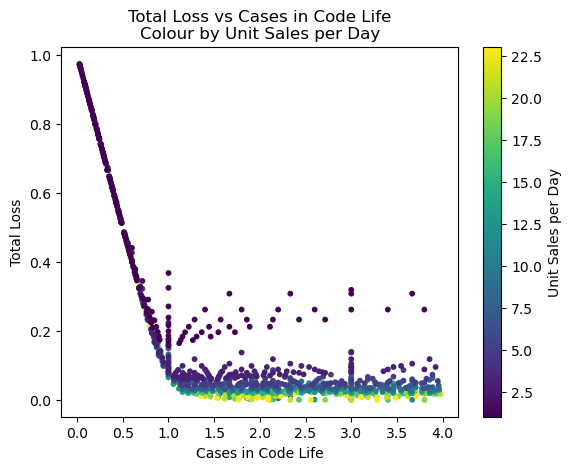

In [35]:
# plt.plot(df_analyse['cases_in_code_life'], df_analyse['total_loss'], '.')

# Now do the same plot but colour the dots by the unit_sales per day
plt.scatter(df_analyse['cases_in_code_life'], df_analyse['total_loss'], c=df_analyse['unit_sales_per_day'], cmap='viridis', s = 10)

plt.xlabel('Cases in Code Life')
plt.ylabel('Total Loss')
plt.colorbar().set_label('Unit Sales per Day')
plt.title('Total Loss vs Cases in Code Life\nColour by Unit Sales per Day')
plt.show()

In [44]:
df_analyse = df[(df['cases_in_code_life'] <= 2.1) & (df['cases_in_code_life'] >= 1.9)]

Text(0.5, 1.0, 'Total Loss vs Unit Sales per Day\nCases in Code Life = 2')

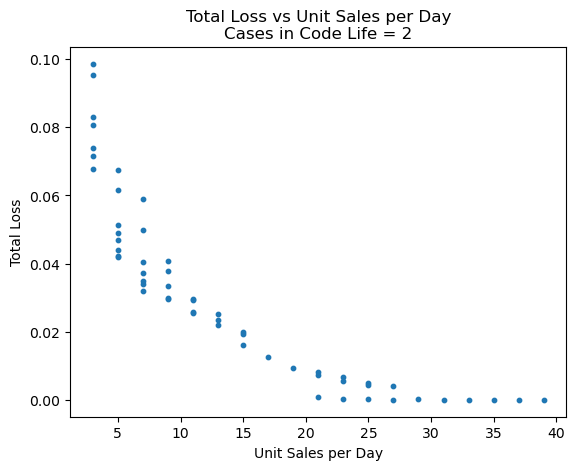

In [48]:
plt.scatter(df_analyse['unit_sales_per_day'], df_analyse['total_loss'], s = 10)
plt.xlabel('Unit Sales per Day')
plt.ylabel('Total Loss')
plt.title('Total Loss vs Unit Sales per Day\nCases in Code Life = 2')


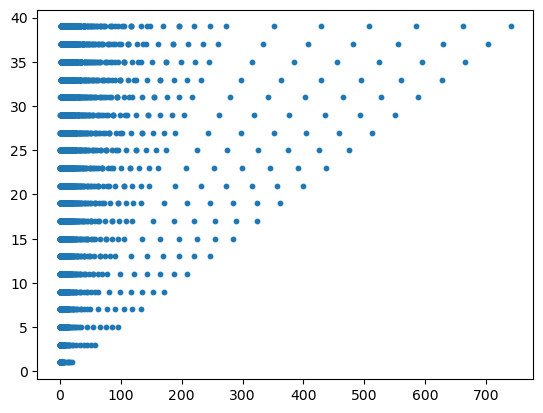

In [52]:
plt.scatter(df['cases_in_code_life'], df['unit_sales_per_day'], s = 10)